#프로젝트 목표

데이터셋을 사용하여 머신러닝 모델을 만든 후 성능 및 인사이트를 도출 / 공유해본다.

데이터 출처: Dacon - [심리 성향 예측 AI 경진대회](https://www.dacon.io/competitions/official/235647/data)

데이터 셋 선정
- 부트캠프 내 데이터셋이 아닌 다른 데이터셋을 활용하였다.

문제 정의
- 부트캠프 내 문제가 아닌 다른 문제를 정의하고 데이터셋으로부터 문제 정의 과정을 제시하였다.
- 문제 정의에 따른 적절한 타겟을 설정하였다.

EDA&전처리
- 데이터 분석 과정과 결과를 설명하였다.
- 데이터를 살펴보고 전처리를 한 과정이 드러나 있다.

Part 2

모델 학습 및 검증
- 모델링 이전에 미리 baseline 모델을 선정하였다.
- 문제 정의에서 언급한 회귀 / 분류 문제에 맞는 모델을 선택하였다.
- 회귀/분류 문제에 따른 적절한 평가지표를 선택하였다.
- 교차검증이나 hold-out을 사용해 데이터셋을 분리하고 모델의 일반화 성능을 검증하였다.
- 모델 최적화를 위한 하이퍼파라미터 튜닝을 진행하였다.

모델 해석
- 모델 결과로서 Test Score를 제시하여 모델을 평가하였다.
- PDP/SHAP/FeatureImportance 등을 활용하여 모델 작동을 설명하였다.
- 모델 학습 결과에 대한 해석이 드러나 있다. (가설 해소 혹은 문제 해결 등)

## Setup

이번 프로젝트에서 사용된 라이브러리 및 기타 전처리 과정을 정리했다.

In [1]:
#깃헙일 때 한번 실행하는 코드입니다.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip -qq "drive/MyDrive/Colab Notebooks/vote_predict_data.zip"

replace open data/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
!pip install category_encoders
!pip install shap
!pip install pdpbox
!pip install eli5
!pip install xgboost

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pdpbox.pdp as pdp
import shap
import eli5

from category_encoders import OrdinalEncoder, TargetEncoder
from eli5.sklearn import PermutationImportance
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.feature_selection import chi2, f_classif, SelectKBest

#데이터 선정 이유 및 문제 정의

- 해결하고자 하는 문제가 적용되는 시나리오를 제시합니다.
- 문제 해결의 필요성에 대해 명확히 제시합니다.
- 데이터셋 선정이 끝났다면 어떤 유형의 문제로 (분류 / 회귀) 접근할지도 결정합니다.
- 데이터셋에서 해결하고자 하는 문제 정의에 적절한 타겟을 선정합니다.
- 타겟을 잘 설명할 수 있을 만한 특성에 대한 가설을 설정합니다.

## 파일 불러오기

프로젝트에 사용하는 파일을 불러온다.

In [5]:
train = pd.read_csv('open data/train.csv',  index_col= 'index')
test  = pd.read_csv('open data/test_x.csv', index_col= 'index')
voted = train['voted'].copy()
train.drop('voted', axis=1, inplace=True)

train.shape, test.shape

((45532, 76), (11383, 76))

## 시나리오

당신은 선거캠프 위원이다. 저번 설문조사 데이터의 결과에서 10대와 20대(이하 YB)에서 투표율이 낮았음을 확인했다. 이 선거 데이터를 통해  YB에 대한 특징을 파악하여 이를 선거전략에 활용할 수 있는지를 알아본다.

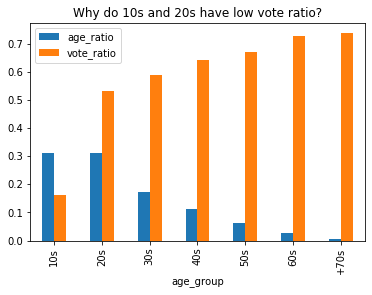

In [6]:
def grid_problem():
  vote_rate = (pd.crosstab(train['age_group'], voted)
    .iloc[:,0] / train['age_group'].value_counts()).sort_values()
  vote_rate.name='vote_ratio'
  count = train['age_group'].value_counts(normalize=True)
  count.name = 'age_ratio'
  dset = pd.DataFrame(
      [count, vote_rate], columns=vote_rate.index
  ).T

  dset.plot(kind='bar', xlabel ='age_group')
  plt.title('Why do 10s and 20s have low vote ratio?')
  #ax1.bar(x = dset2['age_group'])
  
  #return dset

grid_problem()

In [7]:
pd.crosstab(train['hand'], voted)

voted,1,2
hand,,
0,59,102
1,17759,21299
2,2156,2536
3,660,961


## 문제 정의

타겟 데이터를 정의하고 이를 확인합니다. 이번 문제는 분류 문제에 해당됩니다.

In [8]:
def split_Xy(df:pd.DataFrame):
  target_col = 'age_group'
  
  y = df[target_col]
  X = df.drop(target_col, axis= 1)

  return X, y

In [9]:
X_train, y_train = split_Xy(train)
X_test,  y_test  = split_Xy(test)

In [10]:
X_train.dtypes[X_train.dtypes=='object'].index

Index(['gender', 'race', 'religion'], dtype='object')

In [11]:
print(y_train.value_counts())
print('\nThe number of youngsters:',
      y_train.value_counts()[['20s','10s']].sum() /y_train.shape[0])

10s     14215
20s     14112
30s      7836
40s      5051
50s      2889
60s      1194
+70s      235
Name: age_group, dtype: int64

The number of youngsters: 0.6221338838618993


#EDA


- 머신러닝에 적합한 형태로 데이터 타입을 변경합니다.
- 여러 테크닉을 사용해 결측치를 적절히 처리합니다.
- 본인의 전처리 과정에 대해 근거를 들어 설명합니다.
- 피쳐의 분포를 확인하고 이상치를 적절히 제거합니다.
- 1에서 세운 가설과 관련한 시각화 결과를 제시합니다.

## 사용자 정의 함수

해당 파트에서 사용한 사용자 정의 함수 입니다.

In [12]:
def find_contains(lst, cols):
  return lst[lst.str.contains(cols)]

def convert_feature(X:pd.DataFrame):
  cols = X.columns

  for col in cols[cols.str.startswith('tp')]:
    X[col] = 7 - X[col]

  return X

def convert_target(target:pd.Series):
  return pd.Series(
      np.where(target.str.contains('20s|10s'),1,0),
      index=target.index, name='YB')

def grid_heatmap(idx:pd.Series, col:pd.Series):
  idx_count = idx.value_counts().sort_index()
  concat  = pd.concat([idx, col], axis=1)
  crossed = pd.crosstab(concat.iloc[:,0], concat.iloc[:,1])
  for idx in crossed.index:
    crossed.loc[idx,:] /= idx_count[idx]
  return sns.heatmap(crossed)

def grid_bar(idx:pd.Series, col:pd.Series):
  i_name = idx.name
  c_name = col.name
  return sns.barplot(
    data=pd.crosstab(idx, col).reset_index().melt(i_name,var_name=c_name),
    x=i_name, y='value', hue=c_name)

def clue_QA(X:pd.DataFrame, y:pd.Series):
  cols = find_contains(X.columns, 'Q*A')

  plt.figure(figsize=(32,30))
  for i, col in enumerate(cols):
    plt.subplot(5,4,i+1)
    grid_bar(X[col], y)
  plt.legend();
  
def clue_tp(X:pd.DataFrame, y:pd.Series):
  cols = X.columns[X.columns.str.startswith('tp')]

  plt.figure(figsize=(16,30))
  for i, col in enumerate(cols):
    plt.subplot(5,2,i+1)
    grid_bar(X[col], y)
  plt.legend();

def clue_corr(X:pd.DataFrame, y:pd.Series, cols=None):
  feature = None
  if cols == None: feature = X.columns
  else:
    feature = find_contains(X.columns, cols)
  df = pd.merge(X[feature], y, left_index=True, right_index=True)
  return sns.heatmap(df.corr())

def split_undersample(X:pd.DataFrame, y:pd.Series):
  false_idx = y[y==0].index
  true_idx  = y[y==1].index

  X_use, X_dummy, y_use, y_dummy = train_test_split(
      X.loc[true_idx,:], y[true_idx],
      train_size = 0.7, test_size=0.3, random_state=42
  )

  return pd.concat([X_use,X.loc[false_idx,:]]), X_dummy, pd.concat([y_use,y[false_idx]]), y_dummy

##본론

In [13]:
X_train_convert = convert_feature(X_train)
y_train_convert = convert_target(y_train)
X_test_convert = convert_feature(X_test)
y_test_convert = convert_target(y_test)

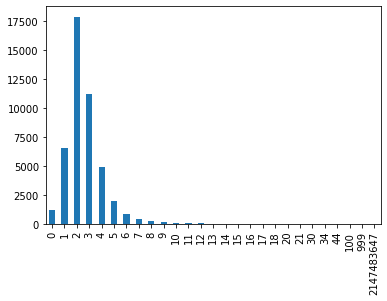

In [14]:
X_train['familysize'].value_counts().sort_index().plot(kind='bar')

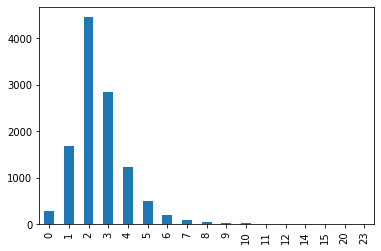

In [15]:
X_test['familysize'].value_counts().sort_index().plot(kind='bar')

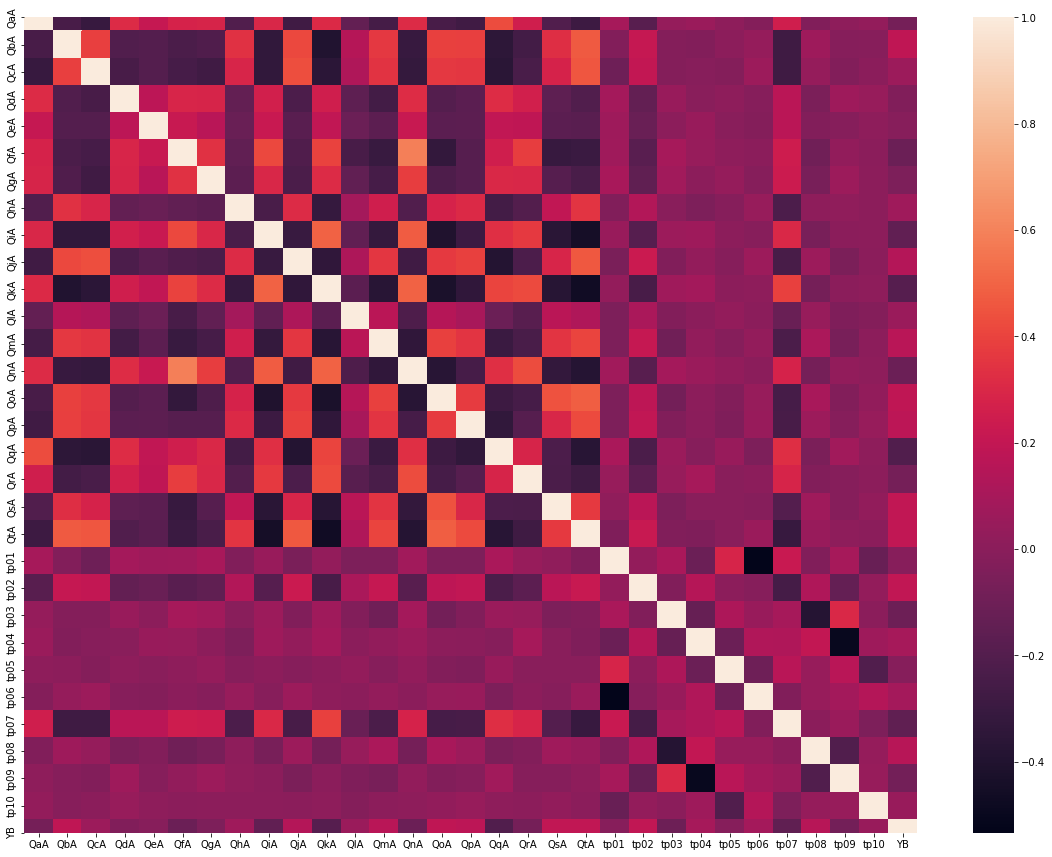

In [16]:
plt.figure(figsize=(20,15))
clue_corr(X_train_convert, y_train_convert, 'Q*A|tp');

QA 그룹

1. QaA, QdA, QeA, QfA, QgA, QiA, QkA, QnA, QqA, QrA, tp07
1. QbA, QcA, QhA, QjA, QlA, QmA, QoA, QpA, QsA, QtA, tp02, target

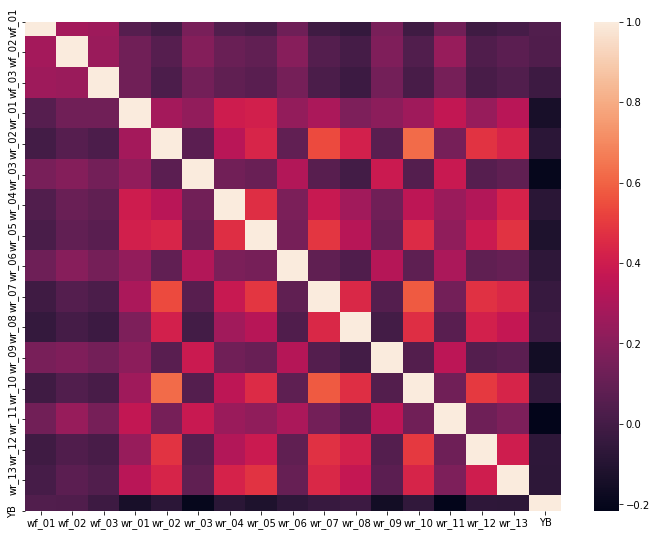

In [17]:
plt.figure(figsize=(12,9))
clue_corr(X_train_convert, y_train_convert, 'wf|wr');

wr, wf 그룹

1. wr_01, wr_02, wr_04, wr_05, wr_07, wr_08, wr_10, wr_12, wr_13
1. wf_01, wf_02, wf_03, wr_03, wr_06, wr_09, wr_11

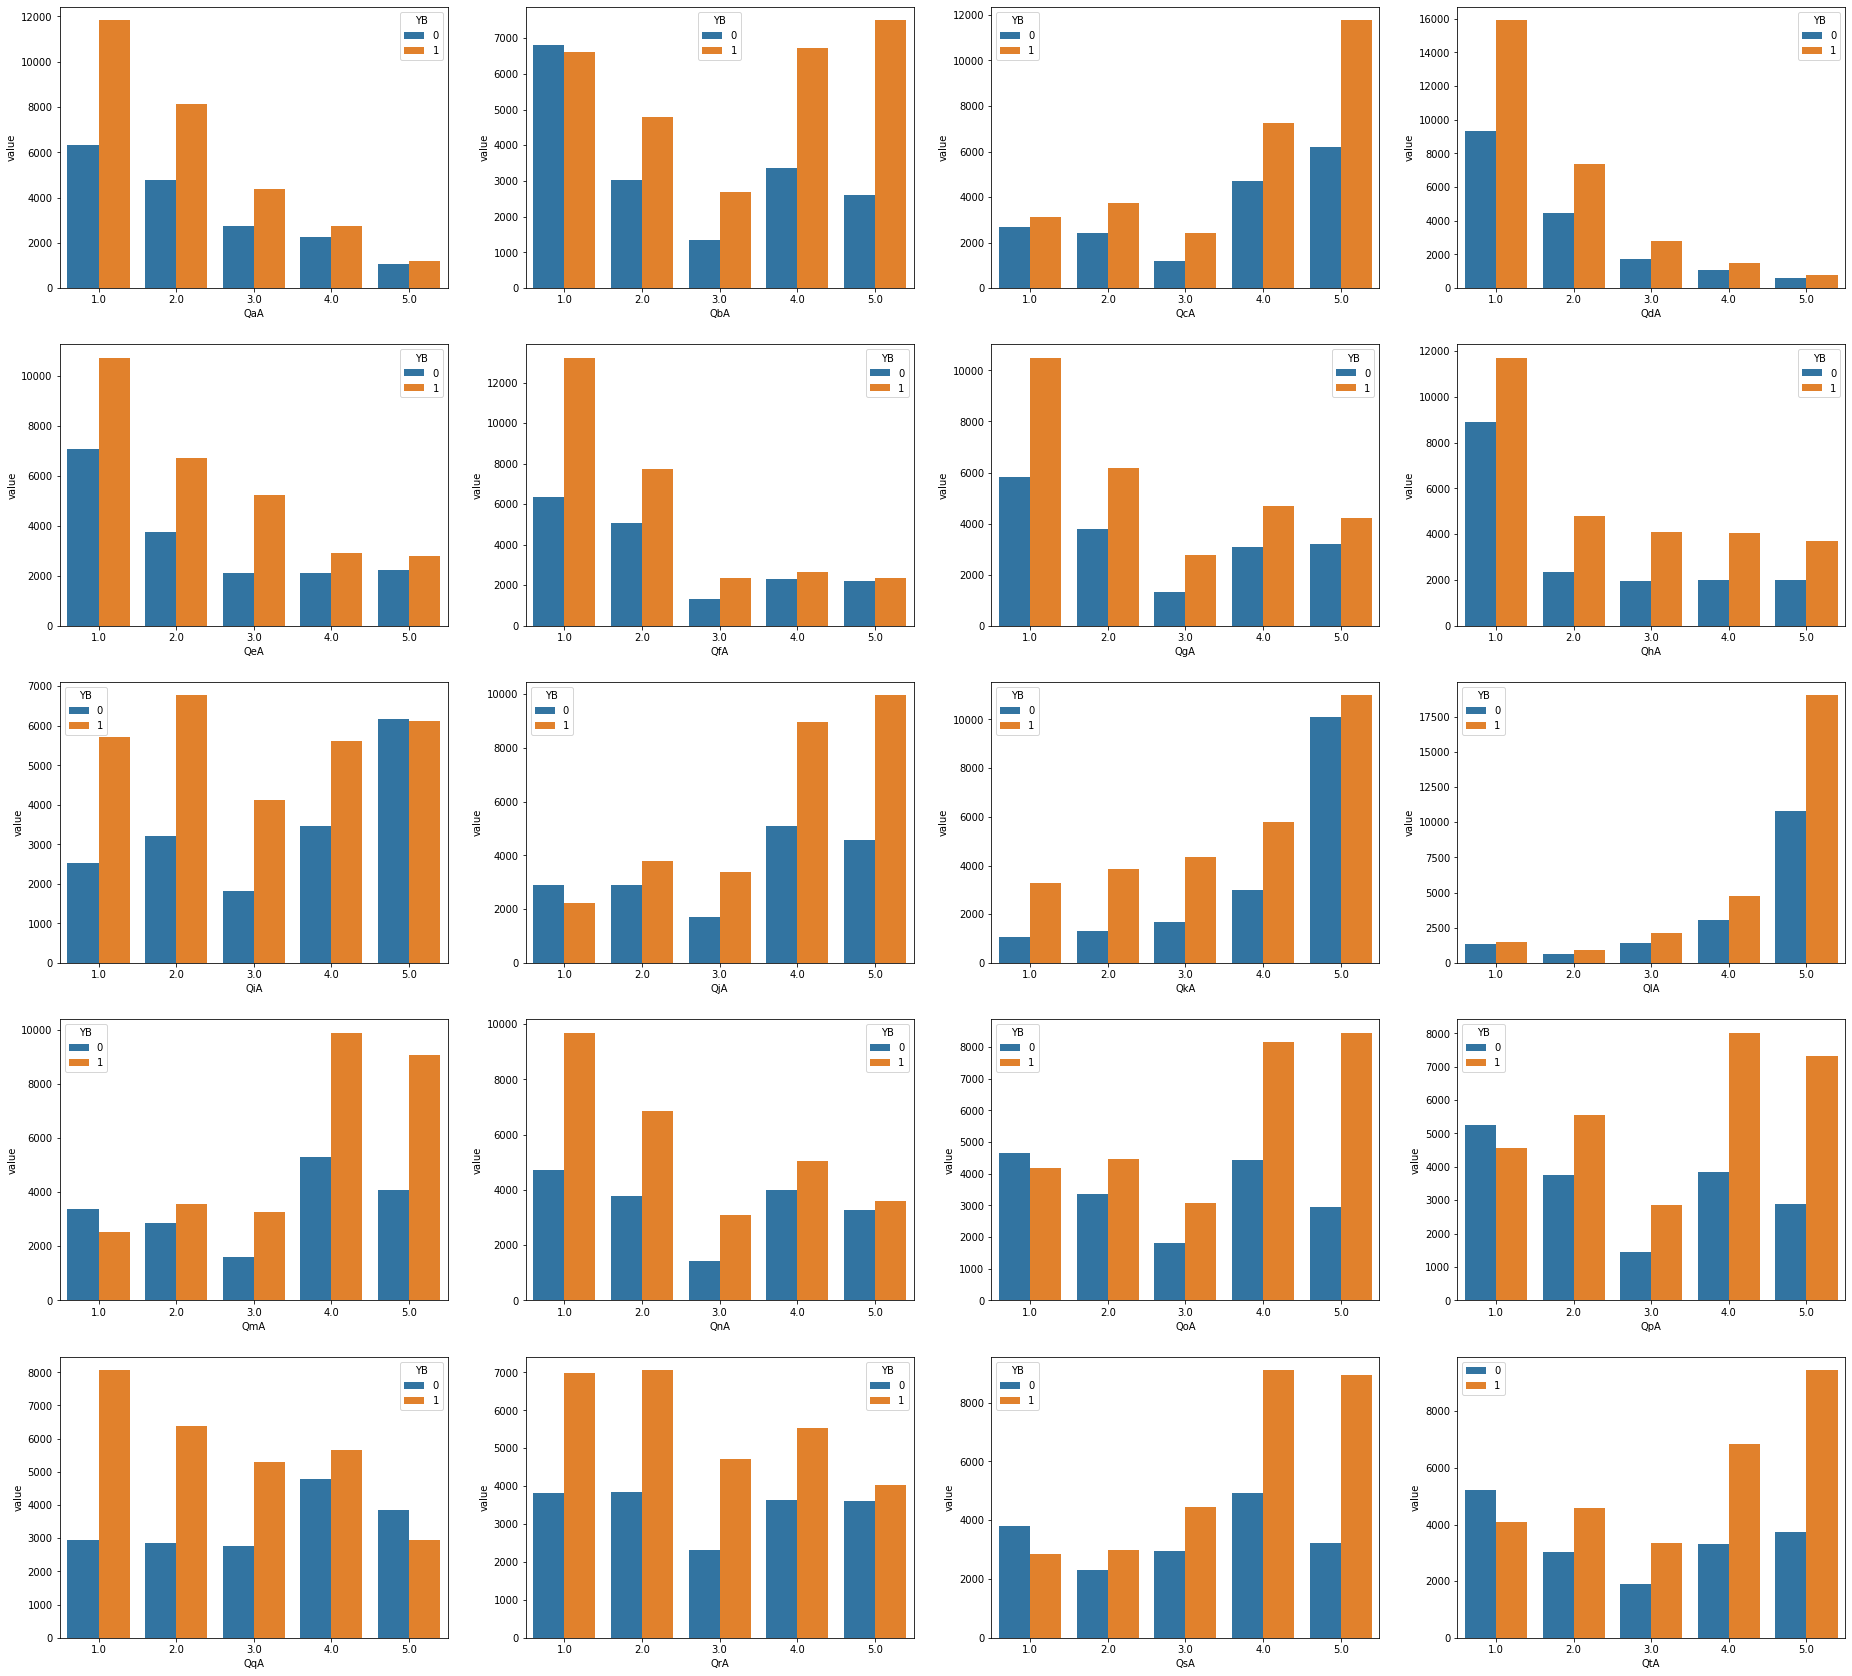

In [18]:
clue_QA(X_train_convert, y_train_convert)

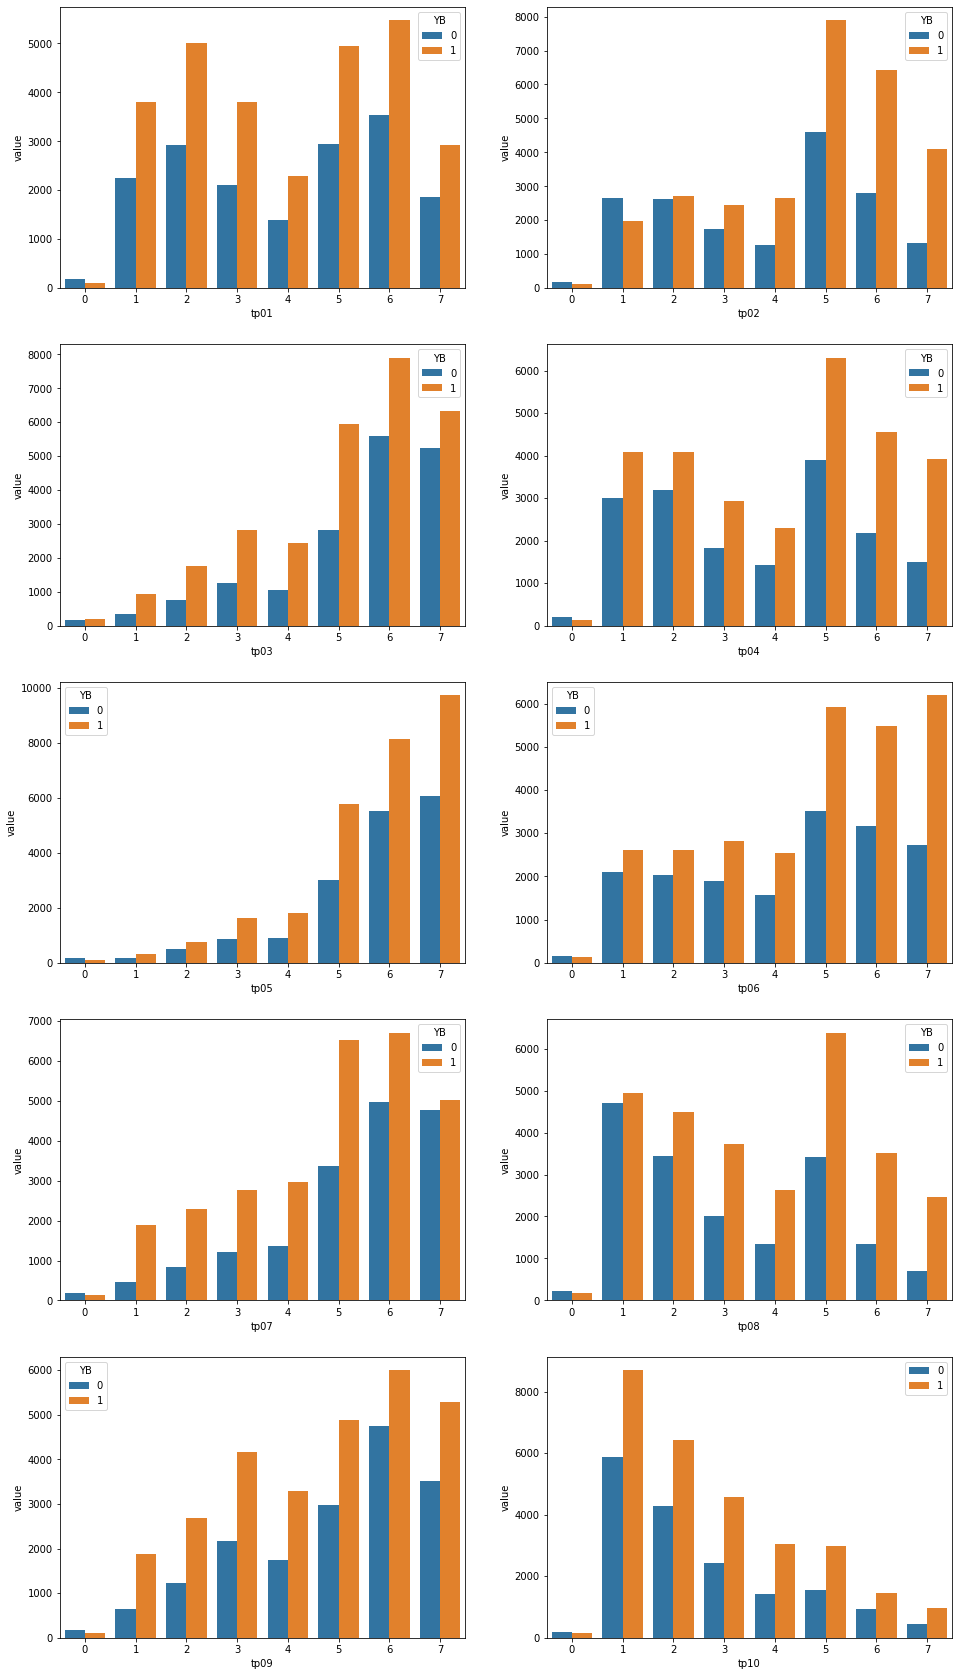

In [19]:
clue_tp(X_train_convert, y_train_convert)

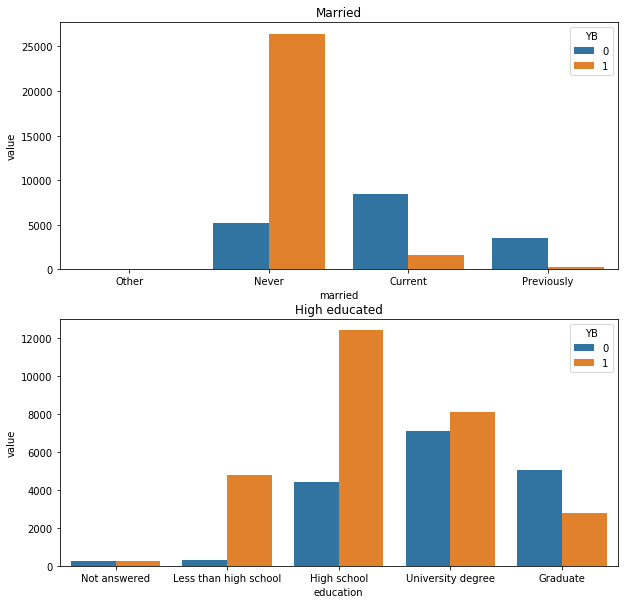

In [20]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
grid_bar(X_train_convert['married'], y_train_convert)
plt.gca().set_xticklabels(["Other", "Never", "Current", "Previously"])

plt.title('Married')
plt.subplot(2,1,2)
grid_bar(X_train_convert['education'], y_train_convert)
plt.gca().set_xticklabels(["Not answered", "Less than high school", "High school", "University degree", "Graduate"])
plt.title('High educated')
plt.show()

## PCA 작업

상관관계가 있는 특성들을 PCA를 이용해 차원축소시킨다.

In [21]:
X_train_use, X_dummy, y_train_use, y_dummy = split_undersample(X_train_convert, y_train_convert)

In [45]:
zip = [
       find_contains(X_train_use.columns, 'Q*A|tp'),
       find_contains(X_train_use.columns, 'wr|wf')
       ]


X_train_pca = X_train_use.query('familysize<100').copy()
X_test_pca = X_test_convert.copy()
X_train_pca.loc[X_train_pca['familysize']>6,'familysize'] = 6
X_test_pca.loc[X_test_convert['familysize']>6,'familysize'] = 6

#cols1 = ['QaA', 'QdA', 'QeA', 'QfA', 'QgA', 'QiA', 'QkA', 'QnA', 'QqA', 'QrA']
#X_train_pca[cols1] = 6 - X_train_pca[cols1]
#X_test_pca[cols1] = 6 - X_test_pca[cols1]

pca = make_pipeline(
    StandardScaler(),
    PCA()
)

for col in zip:
  X_train_pca[col] = pca.fit_transform(X_train_pca[col])
  X_test_pca[col] = pca.transform(X_test_convert[col])
  print(pca.named_steps['pca'].explained_variance_ratio_)

for df in [X_train_pca, X_test_pca]:
  df.drop(['married', 'education'], axis=1, inplace=True)
  #df.drop(find_contains(df.columns, 'Q.E'), axis=1, inplace=True)
  #df.drop(columns=zip[1][3:], inplace=True)
  #df.drop(columns=zip[0][-10:-1], inplace=True)
  #df.drop(columns=zip2[5:], inplace=True)
  #df.drop(columns=zip3[3:], inplace=True)
  #df.drop(columns='wf_02', inplace=True)

y_train_pca = y_train_use[X_train_pca.index]
y_test_pca  = y_test_convert

encoder = TargetEncoder().fit(X_train_pca, y_train_pca)
X_train_pca = encoder.transform(X_train_pca, y_train_pca)
X_test_pca = encoder.transform(X_test_pca, y_test_pca)


X_train_pca.columns

[0.23416704 0.06910218 0.05651479 0.05136796 0.03978543 0.03730328
 0.03462965 0.03166803 0.03025746 0.0298818  0.02900143 0.02586673
 0.02407125 0.02347827 0.02272849 0.02127384 0.02121704 0.02009058
 0.02003393 0.0194719  0.01861803 0.01834808 0.01792338 0.01721128
 0.01699482 0.01543095 0.01501007 0.01363059 0.01286718 0.01205452]
[0.28561809 0.14513735 0.07451867 0.05824628 0.04715426 0.04566849
 0.04451536 0.03956477 0.03873556 0.03718689 0.03495748 0.03391739
 0.03373435 0.0307176  0.02738963 0.02293783]


Index(['QaA', 'QaE', 'QbA', 'QbE', 'QcA', 'QcE', 'QdA', 'QdE', 'QeA', 'QeE',
       'QfA', 'QfE', 'QgA', 'QgE', 'QhA', 'QhE', 'QiA', 'QiE', 'QjA', 'QjE',
       'QkA', 'QkE', 'QlA', 'QlE', 'QmA', 'QmE', 'QnA', 'QnE', 'QoA', 'QoE',
       'QpA', 'QpE', 'QqA', 'QqE', 'QrA', 'QrE', 'QsA', 'QsE', 'QtA', 'QtE',
       'engnat', 'familysize', 'gender', 'hand', 'race', 'religion', 'tp01',
       'tp02', 'tp03', 'tp04', 'tp05', 'tp06', 'tp07', 'tp08', 'tp09', 'tp10',
       'urban', 'wf_01', 'wf_02', 'wf_03', 'wr_01', 'wr_02', 'wr_03', 'wr_04',
       'wr_05', 'wr_06', 'wr_07', 'wr_08', 'wr_09', 'wr_10', 'wr_11', 'wr_12',
       'wr_13'],
      dtype='object')

#모델 만들기

- baseline 모델을 선정하고 이에 기반해 모델링 성능을 평가합니다.
- 반복적인 Feature Engineering 과정을 통해 모델 성능을 최적화합니다.
- 문제 정의에 맞는 평가 지표를 선택하여 모델의 성능을 설명합니다.
- 교차검증이나 hold-out 기법을 사용해 학습 성능과 일반화 성능을 구분하여 제시합니다.
- 여러 수치적 지표 및 permutation importance, pdp, shap 등을 활용하여 최종모델을 설명합니다. 시각화는 설명이 가장 중요합니다.
- 1에서 제시한 가설을 해결합니다.

## Baseline

In [64]:
def analyze_clf(clf:GridSearchCV, X:pd.DataFrame):
  print(f'{clf.best_params_}\n{clf.best_score_}')
  return pd.Series(
      clf.best_estimator_.feature_importances_,
      index = X.columns
      ).sort_values(ascending=False)

def calc_baseline(y):
  match_1 = y.value_counts(normalize=True)[1]
  return match_1 / (match_1 + 1) * 2

In [47]:
calc_baseline(y_train_use)

0.6974200242697104

##LogisticRegression

In [48]:
clf_log = GridSearchCV(
    make_pipeline(
      StandardScaler(),
      LogisticRegression(random_state=2)
      ),
    param_grid={
        'logisticregression__max_iter':[100, 90, 110],
        'logisticregression__C':[0.1 * 1e-4,1 * 1e-4,2 * 1e-4]
    }, scoring='f1', n_jobs=-1, cv=3
)

clf_log.fit(X_train_pca, y_train_pca);

In [49]:
print(f'{clf_log.best_params_}\n{clf_log.best_score_}')

{'logisticregression__C': 0.0001, 'logisticregression__max_iter': 100}
0.7558295537367937


##RandomForest

In [50]:
clf_rdf = GridSearchCV(
    RandomForestClassifier(random_state=2, n_jobs=-1),
    param_grid={
        'min_samples_split':[25, 30, 35],
        'max_depth':[35, 40, 45]
    }, scoring='f1', n_jobs=-1, cv=3
)

clf_rdf.fit(X_train_pca, y_train_pca);

In [51]:
analyze_clf(clf_rdf,X_train_pca)

{'max_depth': 40, 'min_samples_split': 30}
0.7649446170320521


QaA       0.060521
wf_01     0.040135
wf_03     0.037459
QaE       0.033814
race      0.031989
            ...   
wr_05     0.006030
engnat    0.005568
gender    0.002248
urban     0.002062
hand      0.001187
Length: 73, dtype: float64

## XGBClassifier

In [52]:
clf_xgb = GridSearchCV(
    XGBClassifier(random_state=2, n_jobs=-1),
    param_grid={
        'max_delta_step':[30 ,25, 35],
        'max_depth':[5,6,7]
    }, scoring='f1', n_jobs=-1, cv=3
)

clf_xgb.fit(X_train_pca, y_train_pca);

In [53]:
analyze_clf(clf_xgb,X_train_pca)

{'max_delta_step': 30, 'max_depth': 7}
0.7708806464526697


wf_01    0.061910
race     0.057335
wf_03    0.050306
QaA      0.042919
QaE      0.030952
           ...   
wr_05    0.006766
wr_06    0.006660
tp04     0.006558
tp03     0.006328
hand     0.004138
Length: 73, dtype: float32

##Final model: XGBClassifier

In [59]:
analyze_clf(clf_xgb,X_train_pca)[-20:]

{'max_delta_step': 30, 'max_depth': 7}
0.7708806464526697


QrA      0.008314
QlE      0.008046
wr_01    0.008018
QiE      0.008012
wr_10    0.007744
wr_03    0.007729
tp08     0.007614
QfA      0.007508
QoA      0.007415
QgA      0.007376
tp05     0.007274
tp01     0.007232
QnA      0.006922
QiA      0.006875
tp09     0.006798
wr_05    0.006766
wr_06    0.006660
tp04     0.006558
tp03     0.006328
hand     0.004138
dtype: float32

In [60]:
using_col = analyze_clf(clf_xgb,X_train_pca).index[:-1]
X_train_pca_c = X_train_pca[using_col]
X_test_pca_c  = X_test_pca[using_col]

{'max_delta_step': 30, 'max_depth': 7}
0.7708806464526697


In [62]:
clf = GridSearchCV(
    XGBClassifier(random_state=2, n_jobs=-1),
    param_grid={
        'max_iter':[100, 125,150],
        'max_delta_step':[30, 40, 35],
        'max_depth':[7,8,9]
    }, scoring='f1', n_jobs=-1, cv=3
)

clf.fit(X_train_pca_c, y_train_pca);

In [65]:
analyze_clf(clf,X_train_pca_c)

{'max_delta_step': 30, 'max_depth': 7, 'max_iter': 100}
0.7701588046846232


race          0.074110
wf_01         0.072089
QaA           0.050945
wf_03         0.050108
religion      0.036092
QaE           0.033996
QsE           0.027750
QgE           0.026469
engnat        0.026404
familysize    0.026317
QfE           0.023201
QbA           0.019768
wr_11         0.019491
wr_12         0.019440
QnE           0.018651
QjA           0.017860
QhA           0.017588
QlA           0.016270
QeA           0.015708
wr_04         0.015206
QtA           0.014906
gender        0.014891
QpE           0.014795
urban         0.014207
wr_07         0.014068
QrE           0.013849
QdA           0.013512
tp10          0.012983
QeE           0.012982
QkE           0.012500
QpA           0.012430
QqE           0.012217
QmA           0.012078
QtE           0.012051
wr_08         0.011949
QoE           0.011912
QcE           0.011839
QcA           0.011775
QjE           0.011757
QkA           0.011564
QmE           0.011530
QhE           0.010914
QqA           0.010891
wr_02      

In [69]:
f1_score(y_test_pca, clf.best_estimator_.predict(X_test_pca_c))

0.8085348506401138

## 순열중요도 찾기

In [72]:
permut = PermutationImportance(
    clf.best_estimator_,
    scoring = 'f1',
    n_iter = 5,
    random_state = 2
).fit(X_test_pca_c, y_test_convert)

In [73]:
eli5.show_weights(
    permut, 
    top=None,
    feature_names= X_test_pca_c.columns.tolist()
)

Weight,Feature
0.0211 ± 0.0008,QaA
0.0166 ± 0.0035,wf_01
0.0152 ± 0.0032,wf_03
0.0125 ± 0.0033,race
0.0082 ± 0.0022,QbA
0.0075 ± 0.0023,religion
0.0055 ± 0.0012,QlA
0.0055 ± 0.0023,QhA
0.0039 ± 0.0008,familysize
0.0034 ± 0.0025,QjA


#사후 분석

## SHAP

In [74]:
explainer = shap.TreeExplainer(clf.best_estimator_)
s_values = explainer.shap_values(X_test_pca_c)

In [75]:
def guess_result(X, y):
  y_pred = clf.best_estimator_.predict(X)
  
  match_0 = y[(y == 0) & (y_pred == 0)].index
  match_1 = y[(y == 1) & (y_pred == 1)].index
  err_1st = y[(y == 1) & (y_pred == 0)].index
  err_2nd = y[(y == 0) & (y_pred == 1)].index
  return match_1, err_1st, err_2nd, match_0

match_1, err_1st, err_2nd, match_0 = guess_result(X_test_pca_c, y_test_pca)
match_1.shape, err_1st.shape, err_2nd.shape, match_0.shape

((5684,), (1468,), (1224,), (3007,))

In [77]:
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=s_values[match_1[100:200]], 
    features=X_test_pca_c.loc[match_1[100:200],:], 
    link='logit' # SHAP value를 확률로 변환해 표시합니다.
)

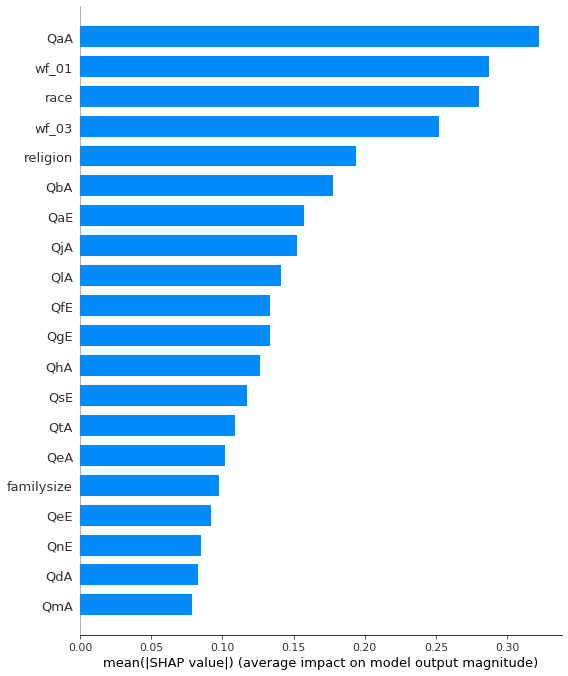

In [82]:
shap.summary_plot(s_values, X_test_pca_c, plot_type='bar')

##PDPBOX

In [85]:
def make_pdp_plot(feat:str):
  df = X_train_pca_c
  return pdp.pdp_plot(
    pdp.pdp_isolate(
        clf.best_estimator_, df,
        model_features= df.columns,
        feature=feat
    ), feature_name=feat
  )
def make_pdp_interact(feat1:str, feat2:str):
  features = [feat1, feat2]
  df = X_train_pca_c

  interaction = pdp.pdp_interact(
    model=clf.best_estimator_, 
    dataset=df,
    model_features=df.columns, 
    features=features
  )
  return pdp.pdp_interact_plot(
      interaction, plot_type='grid',
      feature_names=features);

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fdbbb74de90>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fdbbb849090>})

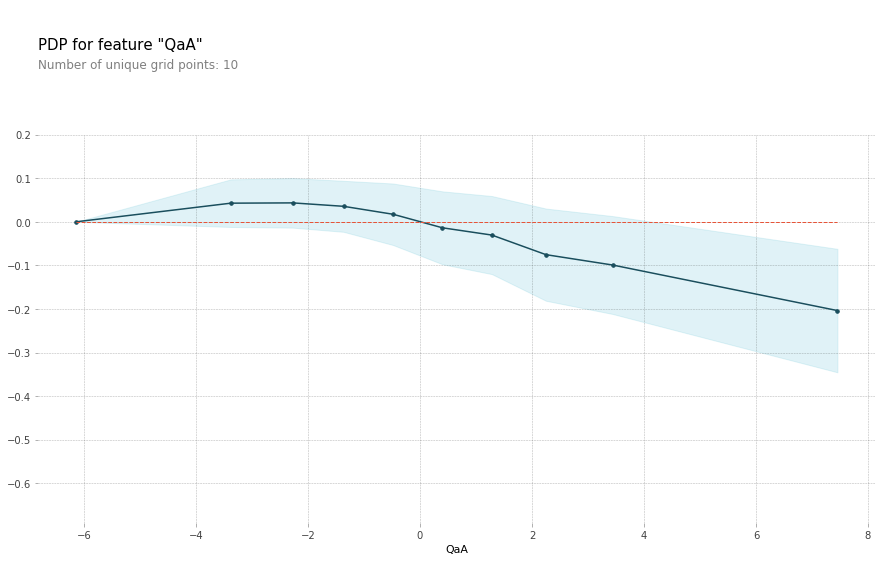

In [86]:
make_pdp_plot('QaA')

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fdbbb6dd4d0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fdbbb726f10>})

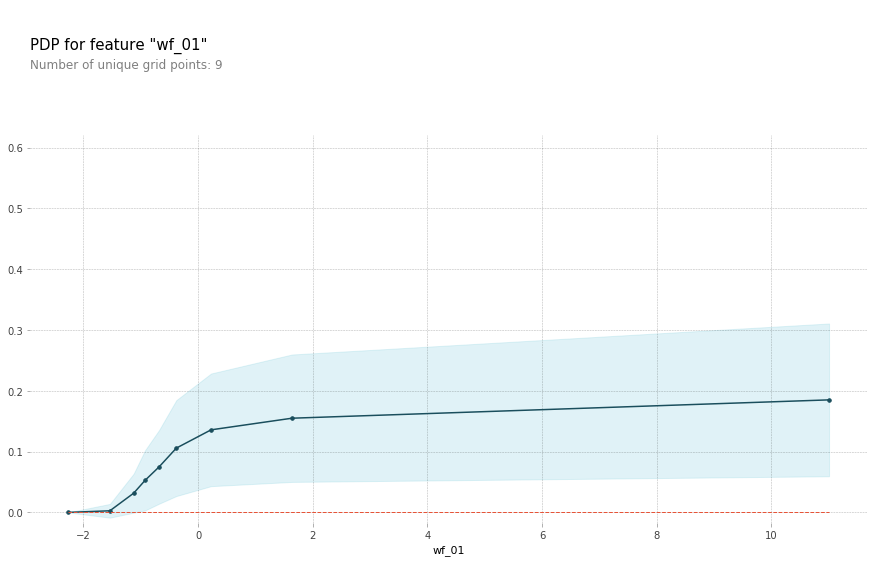

In [87]:
make_pdp_plot('wf_01')

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fdbbb647910>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fdbbb611050>})

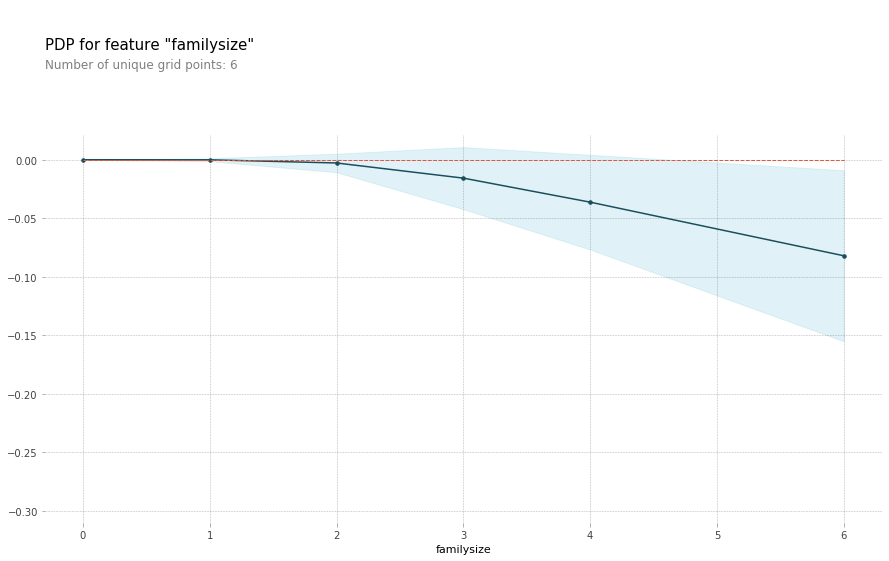

In [88]:
make_pdp_plot('familysize')

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fdbbb4e5690>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fdbbb4fa610>})

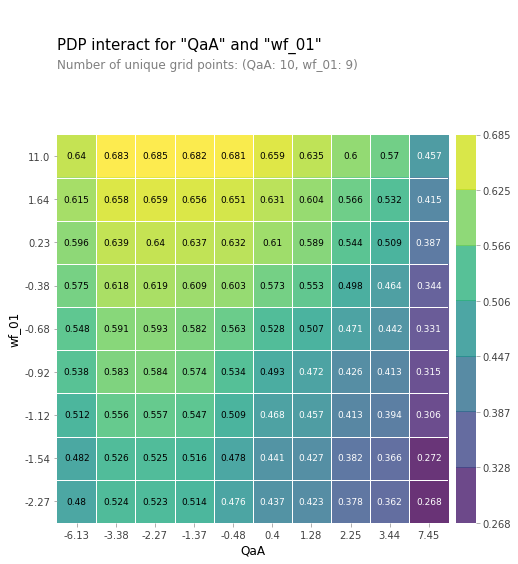

In [89]:
make_pdp_interact('QaA', 'wf_01')

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fdbbb015190>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fdbbb3487d0>})

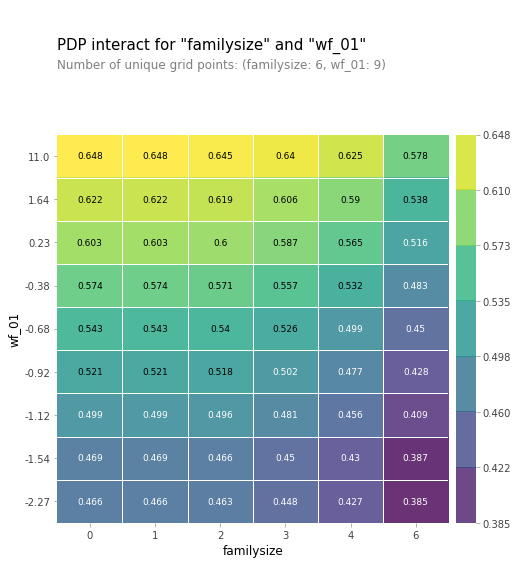

In [91]:
make_pdp_interact('familysize', 'wf_01')

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fdbbb1b4250>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fdbbb2fe9d0>})

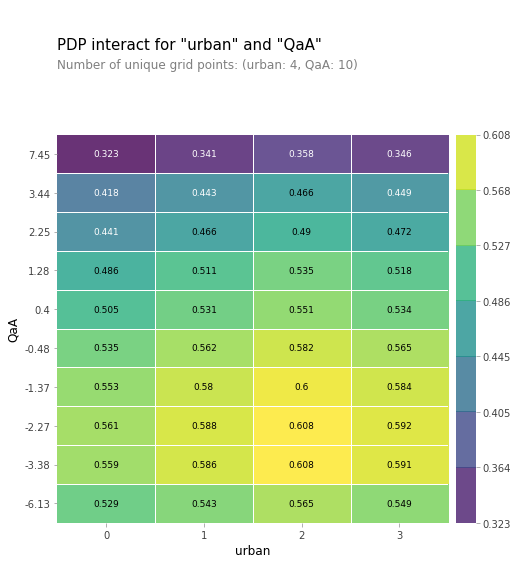

In [90]:
make_pdp_interact('urban', 'QaA')